In [18]:
import numpy as np
import torch
import torch.nn.functional as F
from PIL import Image

import matplotlib.pyplot as plt
from tqdm.auto import tqdm

## Load Stable Diffusion

In [2]:
from ldm.util import instantiate_from_config
from omegaconf import OmegaConf

def load_model_from_config(config, ckpt, device):
    print(f"Loading model from {ckpt}")
    pl_sd = torch.load(ckpt, map_location="cpu")
    sd = pl_sd["state_dict"]
    model = instantiate_from_config(config.model)
    m, u = model.load_state_dict(sd, strict=False)
    model.to(device)
    model.eval()
    return model

In [3]:
device = torch.device("cuda:0")
torch.cuda.set_device(0) # For multiple GPUs

config_path = "configs/stable-diffusion/v1-inference.yaml"
# model_path = ""
model_path = "/nfs/130.245.4.102/add_disk2/agraikos/stable_diffusion_ckpts/v1-5-pruned-emaonly.ckpt"

config = OmegaConf.load(config_path)
model = load_model_from_config(config, model_path, device)

Loading model from /nfs/130.245.4.102/add_disk2/agraikos/stable_diffusion_ckpts/v1-5-pruned-emaonly.ckpt
LatentDiffusion: Running in eps-prediction mode
DiffusionWrapper has 859.52 M params.
making attention of type 'vanilla' with 512 in_channels
Working with z of shape (1, 4, 32, 32) = 4096 dimensions.
making attention of type 'vanilla' with 512 in_channels


/home/agraikos/anaconda3/envs/ldm/lib/python3.8/site-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


## Analyze the convergence of the Inexact Newton algorithm

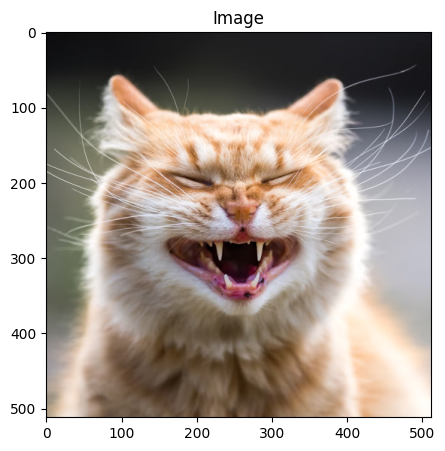

In [4]:
# Load image
img_path = "../assets/thecat.jpg"

x0_img = np.asarray(Image.open(img_path).resize((512,512)))[:,:,:3]
x0_img = torch.from_numpy(x0_img.copy())
x0_img = (x0_img.permute([2,0,1]) / 125.7 - 1).unsqueeze(0).to(device)

with torch.no_grad():
    x0_img_latent = model.get_first_stage_encoding(model.encode_first_stage(x0_img))

fig, ax = plt.subplots(1, 1, figsize=(5,5))
ax.imshow((0.5*(x0_img+1)).clip(0,1)[0].cpu().numpy().transpose([1,2,0]))
ax.set_title("Image")
plt.show()

### Estimate eigenvalues for an $x_t$

In [5]:
def model_pred(model, x, t, cond):
    with torch.no_grad():
        with model.ema_scope():
            t_cond = torch.tensor(x.shape[0]*[t]).view(-1).float().to(device)
            epsilon = model.model.diffusion_model(x, t_cond, context=cond)
    return epsilon

# Select text caption
with torch.no_grad():
    caption = ''
    cond = model.get_learned_conditioning(caption).tile(1,1,1)

# Select timestep
t = 700
if t == 1000:
    xt = torch.randn((1,4,64,64), device=device)
else:
    atbar = model.alphas_cumprod[t-1].view(1,1,1,1)
    xt = torch.sqrt(atbar)*x0_img_latent + torch.sqrt(1-atbar)*torch.randn_like(x0_img_latent)

# Select matrix for which to estimate eigenvalues
matrix = 'J'
# matrix = '(J+JT)/2'
# matrix = '(J-JT)/2'

Computed torch.Size([16384, 11]) torch.Size([11, 10])


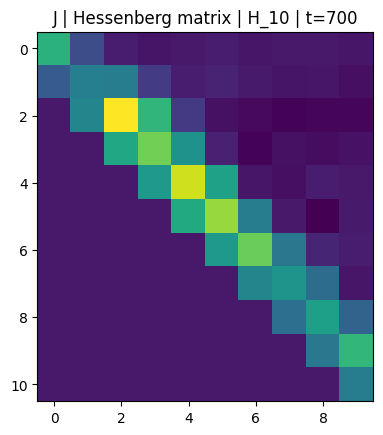

In [ ]:
# Use Arnoldi iteration to estimate the eigenvalues of the Jacobian

# Forward pass function for Je
def jacobian_vector(e):
    with torch.no_grad():
        h = 0.005
        h_adaptive = h / e.abs().max()
        xt_e = xt + h_adaptive*e
        epsilon_e = model_pred(model, xt_e, t, cond)
        x0_pred_e = xt_e / torch.sqrt(atbar) - epsilon_e * torch.sqrt((1-atbar)/atbar)

        grad = (x0_pred_e - x0_pred) / h_adaptive
    return grad

# Forward pass function for J^Te
def denoiser(x):
    t_cond = torch.tensor(x.shape[0]*[t-1]).view(-1).float().to(device)
    epsilon = model.model.diffusion_model(x, t_cond, context=cond.tile(x.shape[0],1,1))
    x0_pred = x / torch.sqrt(atbar) - epsilon * torch.sqrt((1-atbar)/atbar)
    
    return x0_pred

with torch.no_grad():
    epsilon = model_pred(model, xt, t, cond)
    x0_pred = xt / torch.sqrt(atbar) - epsilon * torch.sqrt((1-atbar)/atbar)

im_c, im_h, im_w = x0_pred.shape[1:]

## Arnoldi Iteration ##
# Random initial vector [b]
b = x0_pred

b = b.view(-1)
d = b.shape[0]

# Total vectors to use
n = 10

# Initialize
eps = 1e-6
h = torch.zeros((n + 1, n), device=device)
Q = torch.zeros((d, n + 1), device=device)

# Normalize the input vector
# and use it as the first Krylov vector
Q[:, 0] = b / b.norm() 
for k in range(1, n + 1):
    # Generate a new candidate vector
    # Jv
    with torch.no_grad():
        v1 = jacobian_vector(Q[:, k - 1].view(1,im_c,im_h,im_w))

    # J^Tv
    xt.requires_grad = True
    xt.grad = None
    output = denoiser(xt)
    v2 = torch.autograd.grad((output*Q[:, k - 1].view(1,im_c,im_h,im_w)).sum(), xt, retain_graph=False)[0]
    xt.requires_grad = False

    # Select which eigenvalues to comptue 
    if matrix == 'J':
        v = v1
    elif matrix == 'JT':
        v = v2
    elif matrix == '(J+JT)/2':
        v = (v1 + v2) / 2
    elif matrix == '(J-JT)/2':
        v = (v1 - v2) / 2
    else:
        print("Unknown matrix to compute eigvals for")
        v = v1

    # Subtract the projections on previous vectors
    v = v.view(-1)
    for j in range(k):
        h[j, k - 1] = torch.dot(Q[:, j].conj(), v)
        v = v - h[j, k - 1] * Q[:, j]
    h[k, k - 1] = v.norm()
    # Add the produced vector to the list, unless
    if h[k, k - 1] > eps:
        Q[:, k] = v / h[k, k - 1]
    # Stop iterating
    else: 
        print('Stopped at', k)

print("Computed", Q.shape, h.shape)

plt.figure()
plt.imshow(h.cpu().numpy())
plt.title(f'{matrix} | Hessenberg matrix | H_{n} | t={t}')
plt.show()

Arnoldi iteration | H_10 shape: torch.Size([11, 10])
== Eigenvalues ==
Real min/max: -0.19328700006008148 8.9439697265625
Imaginary min/max: 0.0 0.0
Magnitude min/max: 0.03516162186861038 8.9439697265625


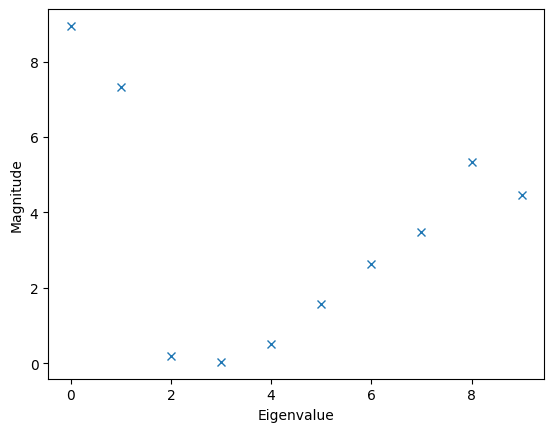

In [7]:
print(f"Arnoldi iteration | H_{n} shape:", h.shape)

eigvals = torch.linalg.eigvals(h[:n,:].view(1,n,n))

print("== Eigenvalues ==")
print("Real min/max:", eigvals.real.min().item(), eigvals.real.max().item())
print("Imaginary min/max:", eigvals.imag.min().item(), eigvals.imag.max().item())
print("Magnitude min/max:", eigvals.abs().min().item(), eigvals.abs().max().item())

plt.figure()
plt.plot(eigvals.abs()[0].cpu().numpy(), 'x')
plt.ylabel("Magnitude")
plt.xlabel("Eigenvalue")
plt.show()

### Run full evaluation

In [15]:
eval_results = {}

# Select text caption
with torch.no_grad():
    caption = ''
    cond = model.get_learned_conditioning(caption).tile(1,1,1)

def model_pred(model, x, t, cond):
    with torch.no_grad():
        with model.ema_scope():
            t_cond = torch.tensor(x.shape[0]*[t]).view(-1).float().to(device)
            epsilon = model.model.diffusion_model(x, t_cond, context=cond)
    return epsilon

for t in [900, 700, 500, 300]:
    print("Running timestep", t)
    eval_results[t] = {}

    ## Initialize ##
    # Sample latent
    if t == 1000:
        xt = torch.randn((1,4,64,64), device=device)
    else:
        atbar = model.alphas_cumprod[t-1].view(1,1,1,1)
        xt = torch.sqrt(atbar)*x0_img_latent + torch.sqrt(1-atbar)*torch.randn_like(x0_img_latent)

    for matrix in ['J', '(J+JT)/2', '(J-JT)/2']:
        eval_results[t][matrix] = None

        # Use Arnoldi iteration to estimate the eigenvalues of the Jacobian

        # Use to compute Je
        def jacobian_vector(e):
            with torch.no_grad():
                h = 0.005
                h_adaptive = h / e.abs().max()
                xt_e = xt + h_adaptive*e
                epsilon_e = model_pred(model, xt_e, t, cond)
                x0_pred_e = xt_e / torch.sqrt(atbar) - epsilon_e * torch.sqrt((1-atbar)/atbar)

                grad = (x0_pred_e - x0_pred) / h_adaptive
            return grad

        # Use to compute J^Te
        def denoiser(x):
            t_cond = torch.tensor(x.shape[0]*[t-1]).view(-1).float().to(device)
            epsilon = model.model.diffusion_model(x, t_cond, context=cond.tile(x.shape[0],1,1))
            x0_pred = x / torch.sqrt(atbar) - epsilon * torch.sqrt((1-atbar)/atbar)
            
            return x0_pred

        with torch.no_grad():
            epsilon = model_pred(model, xt, t, cond)
            x0_pred = xt / torch.sqrt(atbar) - epsilon * torch.sqrt((1-atbar)/atbar)

        im_c, im_h, im_w = x0_pred.shape[1:]

        ## Arnoldi Iteration ##
        # Random initial vector [b]
        b = x0_pred

        b = b.view(-1)
        d = b.shape[0]

        # Total vectors to use
        n = 30

        # Initialize
        eps = 1e-6
        h = torch.zeros((n + 1, n), device=device)
        Q = torch.zeros((d, n + 1), device=device)

        # Normalize the input vector
        # and use it as the first Krylov vector
        Q[:, 0] = b / b.norm() 
        for k in range(1, n + 1):
            # Generate a new candidate vector
            # Jv
            with torch.no_grad():
                v1 = jacobian_vector(Q[:, k - 1].view(1,im_c,im_h,im_w))

            # J^Tv
            xt.requires_grad = True
            xt.grad = None
            output = denoiser(xt)
            v2 = torch.autograd.grad((output*Q[:, k - 1].view(1,im_c,im_h,im_w)).sum(), xt, retain_graph=False)[0]
            xt.requires_grad = False

            # Select which eigenvalues to comptue 
            if matrix == 'J':
                v = v1
            elif matrix == 'JT':
                v = v2
            elif matrix == '(J+JT)/2':
                v = (v1 + v2) / 2
            elif matrix == '(J-JT)/2':
                v = (v1 - v2) / 2
            else:
                print("Unknown matrix to compute eigvals for")
                v = v1

            # Subtract the projections on previous vectors
            v = v.view(-1)
            for j in range(k):
                h[j, k - 1] = torch.dot(Q[:, j].conj(), v)
                v = v - h[j, k - 1] * Q[:, j]
            h[k, k - 1] = v.norm()
            # Add the produced vector to the list, unless
            if h[k, k - 1] > eps:
                Q[:, k] = v / h[k, k - 1]
            # Stop iterating
            else: 
                print('Stopped at', k)

        eigvals = torch.linalg.eigvals(h[:n,:].view(1,n,n))
        max_eigval = eigvals.abs().max().item()
        eval_results[t][matrix] = max_eigval

Running timestep 900
Running timestep 700
Running timestep 500
Running timestep 300


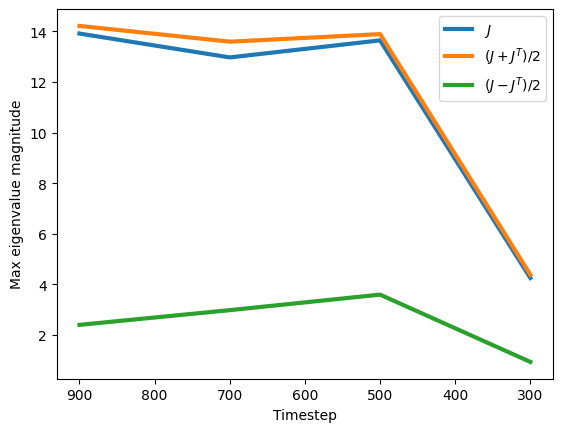

In [ ]:
timesteps = list(eval_results.keys())
j_eigvals = [eval_results[t]['J'] for t in timesteps]
jpjt_eigvals = [eval_results[t]['(J+JT)/2'] for t in timesteps]
jmjt_eigvals = [eval_results[t]['(J-JT)/2'] for t in timesteps]

# Paper results - for reference
# timesteps = [900, 700, 500, 300]
# j_eigvals = [16.85, 8.45, 7.88, 4.98]
# jpjt_eigvals = [16.44, 8.65, 9.00, 6.52]
# jmjt_eigvals = [2.67, 3.35, 2.51, 1.22]

plt.figure()
plt.plot(timesteps, j_eigvals, linewidth=3)
plt.plot(timesteps, jpjt_eigvals, linewidth=3)
plt.plot(timesteps, jmjt_eigvals, linewidth=3)
plt.legend(['$J$', '$(J+J^T)/2$', '$(J-J^T)/2$'])
plt.ylabel('Max eigenvalue magnitude')
plt.xlabel('Timestep')
plt.gca().invert_xaxis()
plt.show()

## Run inference with $\lambda$ from the Arnoldi estimation

0it [00:00, ?it/s]

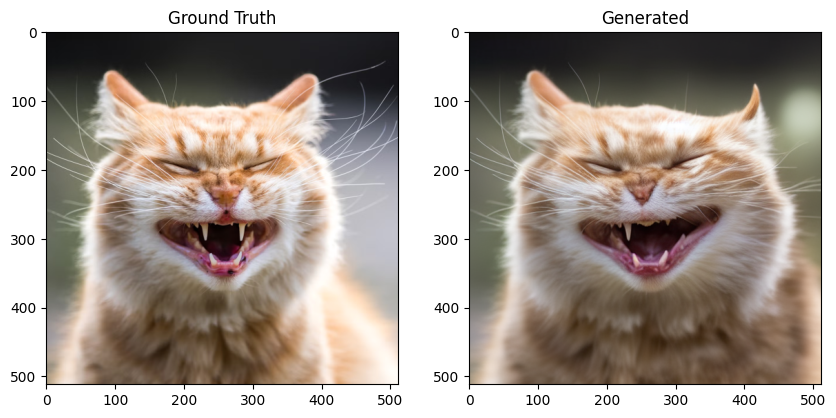

In [44]:
def model_pred(model, x, t, cond):
    with torch.no_grad():
        with model.ema_scope():
            t_cond = torch.tensor(x.shape[0]*[t]).view(-1).float().to(device)
            epsilon = model.model.diffusion_model(x, t_cond, context=cond)
    return epsilon

# Mask right half of the image to use as constraint
latent_mask = torch.zeros((1,4,64,64), device=device)
latent_mask[:,:,:,:32] = 1

# Initialize diffusion
with torch.no_grad():
    x0_constraint = model.get_first_stage_encoding(model.encode_first_stage(x0_img))
    caption = ''
    cond = model.get_learned_conditioning(caption).tile(1,1,1)

t = 1000
xt = torch.randn((1,4,64,64), device=device)
stride = 50
timesteps = range(t, 0, -stride)

# Choose learning rate
learning_rate = 'dynamic' # Used in paper
# learning_rate = '0_5' # |1-λμ^2| = 0.5
# learning_rate = '1_5' # |1-λμ^2| = 1.5
# learning_rate = '3_0' # |1-λμ^2| = 3.0

error_vals = []
timestep_vals = []
bound_vals = []
max_eigval_vals = []

# Run inference
for idx, t in tqdm(enumerate(timesteps)):
    atbar = model.alphas_cumprod[t-1].view(1,1,1,1)
    atbar_prev = model.alphas_cumprod[max(t-1-stride,1)].view(1,1,1,1)
    beta_tilde = (model.betas[t-1] * (1 - atbar_prev) / (1 - atbar)).view(1,1,1,1)

    # Compute x0(x_t)
    epsilon = model_pred(model, xt, t, cond)
    x0_pred = xt / torch.sqrt(atbar) - epsilon * torch.sqrt((1-atbar)/atbar)

    total_error = (latent_mask*((x0_constraint - x0_pred)**2)).sum().item()

    # Inexact Newton steps
    n_steps = 3
    for k in range(n_steps):
        ## Arnoldi iteration ##
        def jacobian_vector(e):
            with torch.no_grad():
                h = 0.005
                h_adaptive = h / e.abs().max()
                xt_e = xt + h_adaptive*e
                epsilon_e = model_pred(model, xt_e, t, cond)
                x0_pred_e = xt_e / torch.sqrt(atbar) - epsilon_e * torch.sqrt((1-atbar)/atbar)

                grad = (x0_pred_e - x0_pred) / h_adaptive
            return grad

        im_c, im_h, im_w = x0_pred.shape[1:]

        # Random initial vector [b]
        b = torch.randn((1,4,64,64), device=device)
        b = b.view(-1)
        d = b.shape[0]

        n = 10
        eps = 1e-6
        h = torch.zeros((n + 1, n), device=device)
        Q = torch.zeros((d, n + 1), device=device)

        # Normalize the input vector
        # and it as the first Krylov vector
        Q[:, 0] = b / b.norm()
        for kk in range(1, n + 1):
            # Jv
            with torch.no_grad():
                v2 = jacobian_vector(Q[:, kk - 1].view(1,im_c,im_h,im_w))
            v = v2

            # Subtract the projections on previous vectors
            v = v.view(-1)
            for j in range(kk):
                h[j, kk - 1] = torch.dot(Q[:, j].conj(), v)
                v = v - h[j, kk - 1] * Q[:, j]
            h[kk, kk - 1] = v.norm()
            # Add the produced vector to the list, unless
            if h[kk, kk - 1] > eps:
                Q[:, kk] = v / h[kk, kk - 1]
            else: # If that happens, stop iterating.
                print('Stopped at', kk)

        eigvals = torch.linalg.eigvals(h[:n,:].view(1,n,n))
        max_eigval = eigvals.abs().max().item()
        ## ################# ##

        ## Inexact Newton ##
        error_dir = latent_mask*(x0_constraint - x0_pred)

        # Compute x_0(x_t + h*e, t)
        h = 0.005
        h_adaptive = h / error_dir.abs().max()
        xt_error_dir = xt + h_adaptive*error_dir
        epsilon_error_dir = model_pred(model, xt_error_dir, t, cond)
        x0_pred_error_dir = xt_error_dir / torch.sqrt(atbar) - epsilon_error_dir * torch.sqrt((1-atbar)/atbar)
        
        # Compute finite differences
        grad = (x0_pred_error_dir - x0_pred) / h_adaptive

        if learning_rate == 'dynamic':
            lr = 0.5 / grad.abs().max()
        elif learning_rate == "0_5":
            lr = 0.5/max_eigval**2
        elif learning_rate == "1_5":
            lr = 1.5/max_eigval**2
        elif learning_rate == "3_0":
            lr = 3.0/max_eigval**2
        else:
            print("Unknown learning rate")
            lr = 0

        # Apply update
        xt = xt + lr*grad

        # Recompute x_0(x_t, t)
        epsilon = model_pred(model, xt, t, cond)
        x0_pred = xt / torch.sqrt(atbar) - epsilon * torch.sqrt((1-atbar)/atbar)
        ## ############## ##

        total_error = (latent_mask*((x0_constraint - x0_pred)**2)).sum().item()

        timestep_vals.append(t)
        error_vals.append(total_error)
        bound_vals.append(abs(1-lr*max_eigval))
        max_eigval_vals.append(np.sqrt(max_eigval))

    # Diffusion step
    xt = torch.sqrt(atbar_prev)*x0_pred + torch.sqrt(1-atbar_prev-beta_tilde)*epsilon + torch.sqrt(beta_tilde)*torch.randn_like(x0_pred)

    with torch.no_grad():
        pred_img = model.decode_first_stage(x0_pred)

fig, ax = plt.subplots(1, 2, figsize=(10,8))
ax[0].imshow((0.5*(x0_img+1)).clamp(0,1)[0].permute([1,2,0]).cpu().numpy())
ax[0].set_title('Ground Truth')
ax[1].imshow((0.5*(pred_img+1)).clamp(0,1)[0].permute([1,2,0]).cpu().numpy())
ax[1].set_title('Generated')
plt.show()


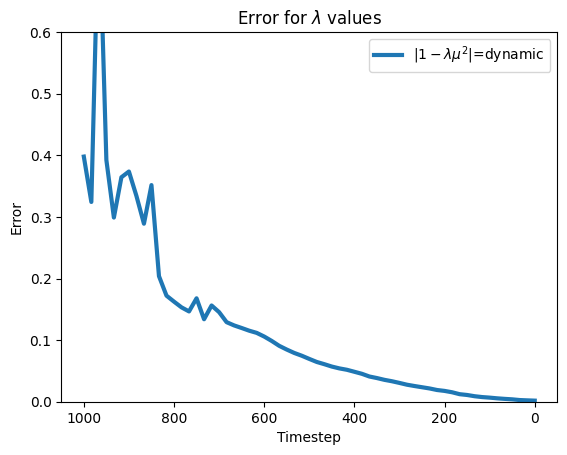

In [45]:
# Plot result
plt.figure()
plt.plot(
    np.linspace(1000, 0, len(error_vals)+1),
    [6520/(4*64*64)] + [e/(4*64*64) for e in error_vals],
    '-', linewidth=3)

plt.legend([f'$|1-\\lambda \\mu^2|$={learning_rate}'])

plt.ylim([0, 0.6])
plt.title('Error for $\\lambda$ values')
plt.xlabel('Timestep')
plt.ylabel('Error')
plt.gca().invert_xaxis()

plt.show()